In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Import custom data generation models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import data_gen_models as data

## Data generating model

We generate data from a toy model with one explanatory variable and one response variable.

In [3]:
# Set a random seed for reproducibility
np.random.seed(2023)

In [41]:
# Choose a data-generating model from the following options (1, 2, 3, 4, or 5)
data_model_index = 5

if data_model_index==1:
    # Linear model with homoscedastic errors
    data_model = data.Model_Reg1()
elif data_model_index==2:
    # Linear model with heteroschedastic errors
    data_model = data.Model_Reg2()
elif data_model_index==3:
    # Linear model with heavy-tail errors
    data_model = data.Model_Reg3()
elif data_model_index==4:
    # Non-linear model with homoscedastic errors
    data_model = data.Model_Reg4()
elif data_model_index==5:
    # Non-linear model with heteroschedastic errors
    data_model = data.Model_Reg4(a=1)
else:
    print("Error: unknown data model")
    data_model = None

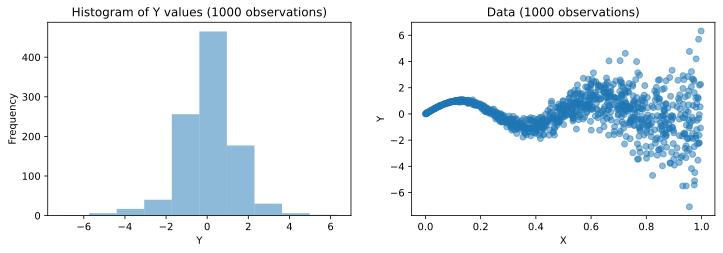

In [42]:
# Generate the labeled data
n_data = 1000
X_data, Y_data = data_model.sample(n_data)

# Generate the test data
n_test = 1000
X_test, Y_test = data_model.sample(n_test)

# Prepare to make side-to-side plots
plt.figure(figsize=(12,3.5))

# Plot histogram of Y values
plt.subplot(1, 2, 1)
plt.hist(Y_data, alpha=0.5)
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Histogram of Y values ({:d} observations)".format(n_data))

# Make scatter plot of the data
plt.subplot(1, 2, 2)
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data ({:d} observations)".format(n_data))
plt.show()

## Warmup: Linear regression

Let's see what happens if we try to apply linear regression to these data.

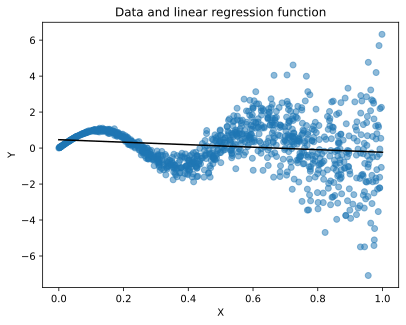

In [43]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Fit a linear model with ordinary least squares
linear_model = sm.OLS(Y_data,sm.add_constant(X_data)).fit()

# Compute the regression function over a fine grid of x-values
x_grid = np.linspace(0,1,1000)
X_grid = np.reshape(x_grid, (len(x_grid),1))
f_hat_linear = linear_model.predict(sm.add_constant(X_grid))

# Plot the regression function
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat_linear, color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data and linear regression function")
plt.show()

We can try to use linear regression theory to compute prediction intervals.  

In [44]:
# Nominal significance level (1 - coverage level)
alpha = 0.1

# Apply the fitted model to the grid of x values
pred_grid = linear_model.get_prediction(sm.add_constant(X_grid)).summary_frame(alpha=alpha)
pred_grid

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.463941,0.082905,0.327448,0.600434,-1.708952,2.636834
1,0.463245,0.082780,0.326957,0.599532,-1.709635,2.636125
2,0.462548,0.082656,0.326465,0.598631,-1.710319,2.635416
3,0.461852,0.082532,0.325974,0.597730,-1.711002,2.634707
4,0.461156,0.082407,0.325482,0.596830,-1.711686,2.633997
...,...,...,...,...,...,...
995,-0.228892,0.082767,-0.365158,-0.092625,-2.401771,1.943987
996,-0.229588,0.082892,-0.366060,-0.093116,-2.402480,1.943304
997,-0.230284,0.083016,-0.366961,-0.093608,-2.403189,1.942620
998,-0.230981,0.083141,-0.367862,-0.094099,-2.403898,1.941937


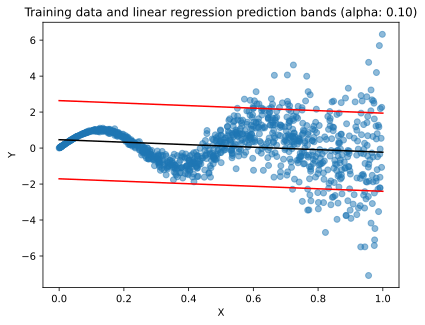

In [45]:
# Plot the prediction bands over the grid of x-values
linear_bands = np.array(pred_grid)[:,[4,5]]

plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat_linear, color="black")
plt.plot(x_grid, linear_bands[:,0], color="red")
plt.plot(x_grid, linear_bands[:,1], color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Training data and linear regression prediction bands (alpha: {:.2f})".format(alpha))
plt.show()

In [46]:
# Construct prediction intervals for all test points
pred_test = linear_model.get_prediction(sm.add_constant(X_test)).summary_frame(alpha=alpha)
pred_test

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.045329,0.044219,-0.027473,0.118130,-2.124495,2.215152
1,-0.021429,0.050550,-0.104654,0.061796,-2.191627,2.148769
2,0.303730,0.056766,0.210271,0.397188,-1.866885,2.474345
3,0.109202,0.041686,0.040572,0.177833,-2.060485,2.278890
4,0.463574,0.082839,0.327189,0.599958,-1.709313,2.636460
...,...,...,...,...,...,...
995,0.404686,0.072576,0.285197,0.524174,-1.767205,2.576577
996,0.051065,0.043835,-0.021105,0.123234,-2.118738,2.220867
997,0.358307,0.064960,0.251359,0.465255,-1.812931,2.529544
998,-0.127860,0.065570,-0.235813,-0.019907,-2.299147,2.043427


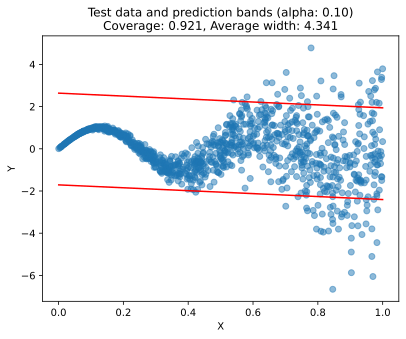

In [47]:
def eval_predictions(X_test, Y_test, lower, upper, show_plot=True):
    covered = (Y_test>=lower) * (Y_test <= upper)
    coverage = np.mean(covered)
    width = np.mean(upper-lower)
        
    # Plot the prediction bands and compare them to the test data
    if show_plot:
        order = np.argsort(X_test[:,0])
        plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
        plt.plot(X_test[order,0], lower[order], color="red")
        plt.plot(X_test[order,0], upper[order], color="red")
        plt.xlabel("X")
        plt.ylabel("Y")
        txt_subtitle = "Coverage: {:.3f}, Average width: {:.3f}".format(coverage, width)
        plt.title("Test data and prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
        plt.show()
    
    return coverage, width
    
# Evaluate the empirical coverage and the average width of the prediction bands
lower = np.array(pred_test)[:,4]
upper = np.array(pred_test)[:,5]    
_, _ = eval_predictions(X_test, Y_test, lower, upper)

## Prediction with a machine learning model

We now fit a more sophisticated machine learning model on the training data.

To learn more about the Python sklearn package: https://scikit-learn.org/stable/index.html

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mfpi.deep_regression import Net as PyTorchNet

# Choose a black-box machine learning model (1,2,3,4,5)
bb_model_index = 5

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Standard scikit-learn neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
elif bb_model_index==5:
    # Custom PyTorch neural network
    black_box = PyTorchNet(X_data.shape[1], dropout=0, learning_rate=0.01,
                           num_epochs=200, batch_size=16, num_hidden=64, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

  0%|          | 0/200 [00:00<?, ?it/s]

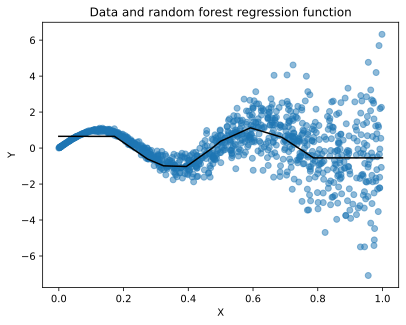

In [51]:
# Fit a random forest to the data
black_box.fit(X_data, Y_data)

# Plot the regression function
f_hat = black_box.predict(X_grid)
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.plot(x_grid, f_hat, color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data and random forest regression function")
plt.show()

How can we assess the uncertainty of the predictions? Let's look at the residuals.

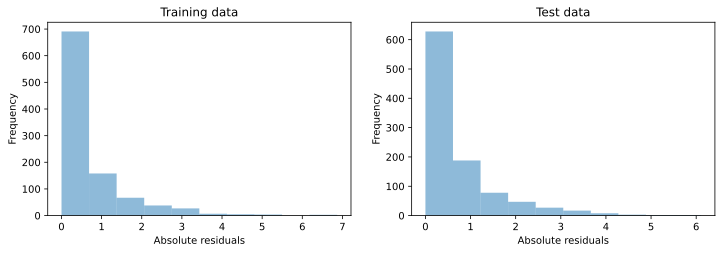

In [52]:
# Compute residuals on data and test data
residuals_data = Y_data - black_box.predict(X_data)
residuals_test = Y_test - black_box.predict(X_test)

# Plot the absolute residuals
plt.figure(figsize=(12,3.5))

plt.subplot(1, 2, 1)
plt.hist(np.abs(residuals_data), alpha=0.5, bins=10)
plt.xlabel("Absolute residuals")
plt.ylabel("Frequency")
plt.title("Training data")
plt.subplot(1, 2, 2)

plt.hist(np.abs(residuals_test), alpha=0.5, bins=10)
plt.xlabel("Absolute residuals")
plt.ylabel("Frequency")
plt.title("Test data")
plt.show()

Residuals on the test data tend to be larger than on the train data due to overfitting.

Therefore, naively trusting the distribution of the residual on the training data would not give valid predictive inferences.  

In [53]:
from scipy.stats.mstats import mquantiles

def naive_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute naive prediction bands based on the distribution of
      residuals within the training data set
      
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Fit the black box model on the training data
    black_box.fit(X, Y)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y - black_box.predict(X))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

  0%|          | 0/200 [00:00<?, ?it/s]

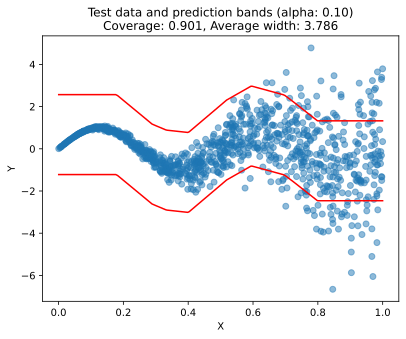

In [54]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower_naive, upper_naive = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_naive, upper_naive)

## Conformal prediction

Let's construct conformal prediction intervals.

Hint: read about the function `train_test_split`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [55]:
from sklearn.model_selection import train_test_split

def conformal_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)
    
    # Fit the black box model on the training data
    black_box.fit(X_train, Y_train)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper  

  0%|          | 0/200 [00:00<?, ?it/s]

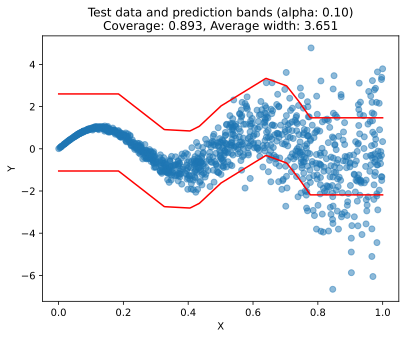

In [56]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower, upper)

## Oracle predictions

Since we know the data generating model, we have access to oracle prediction intervals.

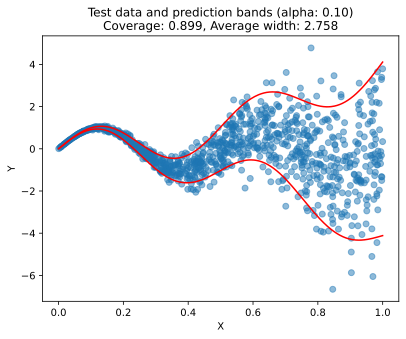

In [57]:
lower_oracle, upper_oracle = data_model.oracle_predict(X_test, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_oracle, upper_oracle)

## Quantile regression

Let's now play fair and forget about the oracle.
We will use a black-box quantile regression model instead.

In [58]:
# Import custom quantile regression models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import qr_models as qr

from mfpi.deep_quantile_regression import QNet as PyTorchQNet

In [65]:
# Choose a black-box quantile regression model (1, 2, or 3)
bb_qr_model_index = 2

alpha = 0.1

if bb_qr_model_index==1:
    # Linear quantile regression model
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    # Quantile random forest
    black_box_qr = qr.RFQR()
elif bb_qr_model_index==3:   
    # Quantile neural network
    black_box_qr = PyTorchQNet([alpha/2,1-alpha/2], X_data.shape[1], no_crossing=True, 
                               dropout=0, learning_rate=0.01,
                               num_epochs=500, batch_size=128, num_hidden=64, random_state=2023, 
                               calibrate=0, verbose=True)
else:
    print("Error: unknown quantile regression model")
    black_box_qr = None

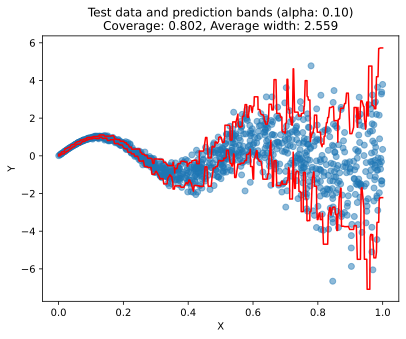

In [66]:
# Fit the quantile regression model
black_box_qr.fit(X_data, Y_data)

# Estimate conditional quantiles for data set
lower_qr, upper_qr = black_box_qr.predict(X_test)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_qr, upper_qr)

## Conformalized quantile regression

Since we don't want to blindly trust the black-box quantile regression model, we will use conformal inference to correct the prediction intervals.

To learn more about quantile regression with random forests in Python: https://pypi.org/project/quantile-forest/

In [68]:
from sklearn.model_selection import train_test_split

def cqr_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)

    # Fit the quantile regression model
    black_box.fit(X_train, Y_train)

    # Estimate conditional quantiles for calibration set
    lower_calib, upper_calib = black_box.predict(X_calib)
    
    # Compute conformity scores on the calibration data
    residuals_calib = np.maximum(Y_calib - upper_calib, lower_calib - Y_calib)
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    lower_test, upper_test = black_box.predict(X_test)
    lower = lower_test - Q_hat
    upper = upper_test + Q_hat
    
    return lower, upper 

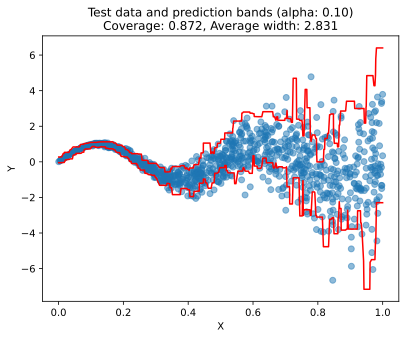

In [69]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower_cqr, upper_cqr = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_cqr, upper_cqr)